<a href="https://colab.research.google.com/github/beatricekiplagat/Deepfake-Audio-Recognition/blob/main/CNN_custom.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
!pip install wandb

In [13]:
import wandb
from wandb.keras import WandbCallback

In [14]:
import os

In [15]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [16]:
train_dir = '/content/drive/MyDrive/DEEPFAKE AUDIO DETECTION PROJECT/DATASETS/Train'
validation_dir = "/content/drive/MyDrive/DEEPFAKE AUDIO DETECTION PROJECT/DATASETS/Test"

In [17]:
train_spoof = "/content/drive/MyDrive/DEEPFAKE AUDIO DETECTION PROJECT/DATASETS/Train/Spoof"
train_bonafide = "/content/drive/MyDrive/DEEPFAKE AUDIO DETECTION PROJECT/DATASETS/Train/Bonafide"
test_spoof = "/content/drive/MyDrive/DEEPFAKE AUDIO DETECTION PROJECT/DATASETS/Test/Spoof"
test_bonafide = "/content/drive/MyDrive/DEEPFAKE AUDIO DETECTION PROJECT/DATASETS/Test/Bonafide"

In [18]:
print('total training spoof images:', len(os.listdir(train_spoof)))
print('total training bonafide images:', len(os.listdir(train_bonafide)))



print('total test spoof images:', len(os.listdir(test_spoof)))
print('total test bonafide images:', len(os.listdir(test_bonafide)))

total training spoof images: 799
total training bonafide images: 851
total test spoof images: 201
total test bonafide images: 199


In [22]:
from tensorflow.keras import layers
from tensorflow.keras import models

#Created sequential models using Keras
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 128)       1

In [23]:
from tensorflow.keras.optimizers import Adam
# opt = RMSprop(lr=1e-4)
opt = Adam(lr=1e-4)
model.compile(loss='binary_crossentropy', 
              optimizer=opt,
              metrics=['acc'])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [24]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=(150, 150), 
                                                    batch_size=20, # batch size in models 
                                                    class_mode='binary')

validation_generator = test_datagen.flow_from_directory(validation_dir,
                                                        target_size=(150, 150),
                                                        batch_size=20,
                                                        class_mode='binary')

Found 1650 images belonging to 2 classes.
Found 400 images belonging to 2 classes.


Let’s fit the model to the data using the generator. You do so using the fit_generator method, the equivalent of fit for data generators like this one. It expects as its first argument a Python generator that will yield batches of inputs and targets indefinitely,like this one does. Because the data is being generated endlessly, the Keras model needs to know how many samples to draw from the generator before declaring anepoch over. This is the role of the `steps_per_epoch` argument: after having drawn `steps_per_epoch` batches from the generator—that is, after having run for `steps_per_epoch` gradient descent steps—the fitting process will go to the next epoch. In this case, batches are 20 samples, so it will take 100 batches until you see your target of 2,000 samples.

When using fit_generator, you can pass a validation_data argument, much as with the fit method. It’s important to note that this argument is allowed to be a data generator, but it could also be a tuple of Numpy arrays. If you pass a generator as validation_data, then this generator is expected to yield batches of validation data endlessly; thus you should also specify the validation_steps argument, which tells the process how many batches to draw from the validation generator for evaluation.

In [10]:
run = wandb.init(project='DeepFake Audio Detection', entity='ruoro', save_code=True, 
           config = {
               'learning_rate': 0.0001,
               'epochs': 7,
               'batch_size' : 4,
               'loss_function' : 'binary_crossentropy'
           })
run

wandb: Currently logged in as: ruoro (use `wandb login --relogin` to force relogin)


In [28]:
history = model.fit_generator(train_generator,
                              steps_per_epoch=30,
                              epochs=30,
                              validation_data=validation_generator,
                              validation_steps=10,
                              callbacks = [WandbCallback(data_type = "image", generator = validation_generator) ])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1969: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/30
30/30 [==============================] - 9s 285ms/step - loss: 0.4644 - acc: 0.7850 - val_loss: 0.3897 - val_acc: 0.8250
Epoch 2/30
30/30 [==============================] - 8s 281ms/step - loss: 0.3795 - acc: 0.8417 - val_loss: 0.3389 - val_acc: 0.9050
Epoch 3/30
30/30 [==============================] - 8s 275ms/step - loss: 0.3594 - acc: 0.8783 - val_loss: 0.2622 - val_acc: 0.9200
Epoch 4/30
30/30 [==============================] - 8s 273ms/step - loss: 0.2495 - acc: 0.9217 - val_loss: 0.2395 - val_acc: 0.9050
Epoch 5/30
30/30 [==============================] - 8s 275ms/step - loss: 0.2334 - acc: 0.9217 - val_loss: 0.1624 - val_acc: 0.9500
Epoch 6/30
30/30 [==============================] - 8s 279ms/step - loss: 0.2039 - acc: 0.9339 - val_loss: 0.1469 - val_acc: 0.9550
Epoch 7/30
30/30 [==============================] - 8s 272ms/step - loss: 0.2340 - acc: 0.9233 - val_loss: 0.1939 - val_acc: 0.9250
Epoch 8/30
30/30 [==============================] - 8s 269ms/step - loss: 0.

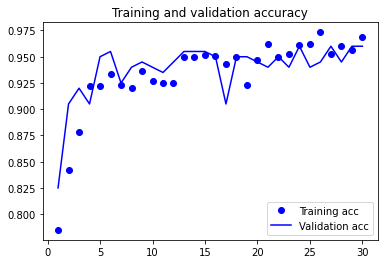

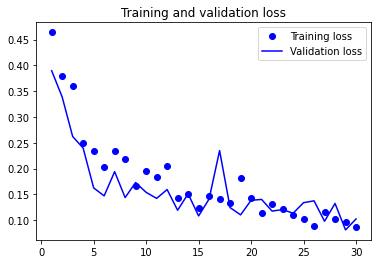

In [29]:
# model.save('soundmodel.h5')

import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [47]:
from tensorflow.keras.models import load_model
model = load_model ('/content/soundmodel.h5')

In [53]:
import cv2
import numpy as np

# img_path = "/content/drive/MyDrive/DEEPFAKE AUDIO DETECTION PROJECT/DATASETS/Test/Spoof/LA_D_1099173.png"
# img_path = "/content/drive/MyDrive/DEEPFAKE AUDIO DETECTION PROJECT/DATASETS/Test/Spoof/LA_D_2367943.png"
# img_path = "/content/drive/MyDrive/DEEPFAKE AUDIO DETECTION PROJECT/DATASETS/Test/Bonafide/LA_D_1481335.png"
img_path = "/content/drive/MyDrive/DEEPFAKE AUDIO DETECTION PROJECT/DATASETS/Test/Bonafide/LA_D_2412960.png"
# img_path = "/content/drive/MyDrive/DEEPFAKE AUDIO DETECTION PROJECT/DATASETS/Test/Bonafide/LA_D_2436364.png"

img = cv2.imread(img_path)
# img = cv2.imread(img_path)
img = cv2.resize(img, (150, 150))

x = np.expand_dims(img, axis=0)
# # Now predict the class of image. 
preds = model.predict(x)

preds
# if preds == 1:
#   print ("Spoofed Audio")
# else:
#   print('Bonafide')


array([[0.]], dtype=float32)

In [44]:
model = wandb.Artifact('soundmodel', type='model')
model.add_file('soundmodel.h5')

run.log_artifact(model)

In [45]:
wandb.finish()

acc,0.96833
best_epoch,28
best_val_loss,0.08086
epoch,29
loss,0.08634
val_acc,0.96
val_loss,0.10212


acc,▁▂▄▅▆▇▇▇▇▇▇▇▇▇████▇█▇▇██████████
epoch,▁▁▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
loss,█▇▆▅▄▃▃▂▃▃▂▂▂▃▂▂▁▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁
val_acc,▁▁▃▆▇▆██▇▇▇▇▇▇████▆██▇▇█▇█▇▇█▇██
val_loss,█▇▆▅▄▄▂▂▃▂▂▂▂▂▂▂▁▂▃▂▁▂▂▂▂▂▂▂▁▂▁▁
